In [1]:
# General
import pandas as pd
import numpy as np
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline

# ML
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
import joblib
from xgboost import XGBRegressor 

# Cp 
from cp_app.utils import select_structures
from cp_app.descriptors import cv_features
from cp_app.predictions import predict_Cv_ensemble_structure

# others
import warnings
warnings.filterwarnings('ignore')

/Users/mohamad/anaconda3/envs/cp_env/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Setting up the model, target, and features

In [2]:

FEATURES = cv_features
TARGET = 'pCv_300.00' 
temperature="300.00"

In [3]:
def xgb_model(best_params, X, FEATURES, TARGET):
    pipe_xgb = Pipeline(
        [
       ('scaling', StandardScaler()), 
       ('variance_threshold', VarianceThreshold(threshold=0.95)),
       ('xgb', XGBRegressor())
       
       ]
    )
    pipe_xgb.set_params(xgb__reg_lambda = best_params["xgb__reg_lambda"])
    pipe_xgb.set_params(xgb__reg_alpha = best_params["xgb__reg_alpha"])
    pipe_xgb.set_params(xgb__n_estimators = best_params["xgb__n_estimators"])
    pipe_xgb.set_params(xgb__max_depth = best_params["xgb__max_depth"])
    pipe_xgb.set_params(xgb__learning_rate = best_params["xgb__learning_rate"])
    
    pipe_xgb.fit(X[FEATURES], X[TARGET])
    
    return pipe_xgb
    

In [4]:
## these were obtained using hyperopt
xgb_hyperparams = {
    'xgb__reg_lambda': 0.049238826317067365,
    'xgb__reg_alpha': 0.049238826317067365,
    'xgb__n_estimators': 300,
    'xgb__max_depth': 10,
    'xgb__learning_rate': 0.1
}

## Data loading, and train test split,...

In [5]:
RANDOM_SEED = 3982
DATA_DIR = 'data/'
DATA_site = 'alldata.csv'
DATA_structure = 'structures_data.csv'
flag="smallML_120_10" # name_#TrainSize_#EnsembleSize 
N_ensemble = int(flag.split("_")[2])
N_train=int(flag.split("_")[1])

In [6]:
df_structures=pd.read_csv(DATA_DIR+DATA_structure)
df_allsites = pd.read_csv(DATA_DIR+DATA_site)
print("Total structures: ", len(df_structures))

Total structures:  232


### train test split, making sure we have diverse training set

In [7]:
inds=select_structures(N_train,df_structures)
df_train_structures=df_structures.loc[df_structures.index.isin(inds)]
df_test_structures=df_structures.loc[~df_structures.index.isin(inds)]
df_train_structures.to_csv(DATA_DIR+"train_structures.csv")
df_test_structures.to_csv(DATA_DIR+"test_structures.csv")
print("{} structures in training set".format(len(df_train_structures)))
print("{} structures in test set".format(len(df_test_structures)))

120 structures in training set
112 structures in test set


In [8]:
df = df_allsites.loc[df_allsites["structure_name"].isin(df_train_structures["Unnamed: 0"])]
df_site_test = df_allsites.loc[~df_allsites["structure_name"].isin(df_train_structures["Unnamed: 0"])]
df.to_csv(DATA_DIR+"site_train.csv",index=False)

In [9]:
THRESHOLD =df[TARGET].median()
train_size=min(int(0.95*len(df)),max(10000,len(df)))
test_size=len(df)-train_size
df['target_binned'] = [1 if value > THRESHOLD else 0 for value in df[TARGET]]
df_train_stratified, df_test_stratified = train_test_split(df, train_size=train_size, 
                                                                test_size=test_size, 
                                                                random_state=RANDOM_SEED, 
                                                                stratify=df['target_binned']) 

### Generating bootstrapped trainset for quantifying uncertainty

In [10]:
Xs = []
for i in range(N_ensemble):
    X = resample(df_train_stratified, replace=True,random_state=i) 
    Xs.append(X)

## Training models

In [18]:
models = []
for i,X in enumerate(Xs):
    model = xgb_model(xgb_hyperparams, X, FEATURES, TARGET)
    models.append(model)
p = pathlib.Path("ensemble_models_{}/{}".format(flag,temperature))
p.mkdir(parents=True, exist_ok=True)
for i,model in enumerate(models):
    joblib.dump(model,"ensemble_models_{}/{}/model_{}".format(flag,temperature,i))

## Testing the model

### Train set

sites in trainset

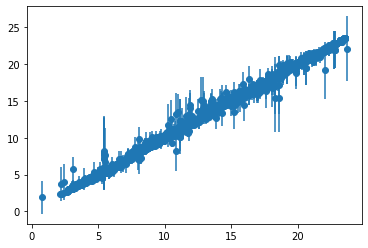

In [12]:
predictions = []
for model in models:
    prediction = model.predict(df_train_stratified[FEATURES])
    predictions.append(prediction)
    
predictions = np.array(predictions)
plt.errorbar(df_train_stratified[TARGET],np.mean(predictions,axis = 0), yerr=np.std(predictions,axis = 0), linestyle="None")
plt.scatter(df_train_stratified[TARGET],np.mean(predictions,axis = 0))

sites that were not in the training set but in the training structures

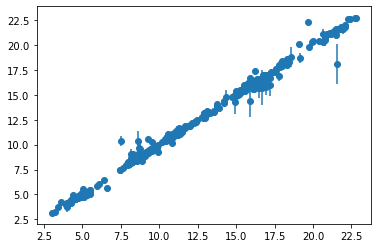

In [13]:
predictions = []
for model in models:
    prediction = model.predict(df_test_stratified[FEATURES])
    predictions.append(prediction)
    
predictions = np.array(predictions)
plt.errorbar(df_test_stratified[TARGET],np.mean(predictions,axis = 0), yerr=np.std(predictions,axis = 0), linestyle="None")
plt.scatter(df_test_stratified[TARGET],np.mean(predictions,axis = 0))

### Test set

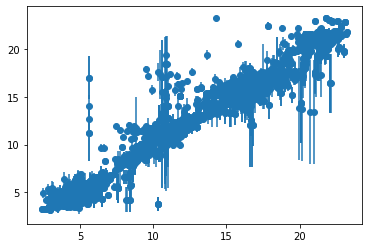

In [14]:
predictions_new = []
for model in models:
    prediction = model.predict(df_site_test[FEATURES])
    predictions_new.append(prediction)
    
predictions_new = np.array(predictions_new)
plt.errorbar(df_site_test[TARGET],np.mean(predictions_new,axis = 0), yerr=np.std(predictions_new,axis = 0), linestyle="None")
plt.scatter(df_site_test[TARGET],np.mean(predictions_new,axis = 0))

In [15]:
Cvs = []
values = df_site_test["structure_name"].unique()
for name in values:
    Cv = predict_Cv_ensemble_structure(ensemble_models=models, FEATURES=FEATURES, df_features=df_site_test, structure_name=name)
    Cvs.append({"name": name, "Cv_gravimetric_predicted_mean":Cv[0],"Cv_gravimetric_predicted_std":Cv[1]
                    ,"Cv_molar_predicted_std":Cv[2], "Cv_molar_predicted_std":Cv[3], 
                "Cv_gravimetric":df_structures.loc[df_structures["Unnamed: 0"]==name]["Cv_gravimetric_300.00"]
                   })

In [16]:
df_Cvs = pd.DataFrame(Cvs)

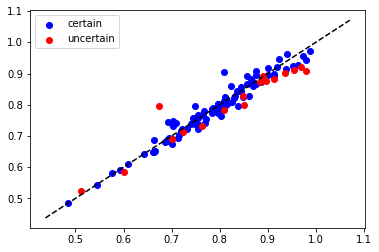

In [17]:
certain=df_Cvs.loc[df_Cvs["Cv_gravimetric_predicted_std"]<0.01]
uncertain=df_Cvs.loc[df_Cvs["Cv_gravimetric_predicted_std"]>=0.01]
plt.scatter(certain["Cv_gravimetric"],certain["Cv_gravimetric_predicted_mean"],label="certain",c="b")
plt.scatter(uncertain["Cv_gravimetric"],uncertain["Cv_gravimetric_predicted_mean"],label="uncertain",c="r")
xr=np.linspace(0.9*min(df_Cvs["Cv_gravimetric_predicted_mean"]),1.1*max(df_Cvs["Cv_gravimetric_predicted_mean"]),100)
plt.plot(xr,xr,"k--")
plt.legend()